# Modelle (Word2Vec, Doc2Vec) sowie Evaluation aller Modelle

In [1]:
# Inhaltverzeichnis:
'''
1. Datenaufbereitung
2. Methodendeklaration, Hilfsfunktion, unsw.
3. Training (Word2Vec, Doc2Vec)
4. Laden der Training-Ergebnisse von LinkPred, Knowledge Graph
5. Testing aller Modelle (Word2Vec, Doc2Vec, LinkPred, Know. Graph)
6. Weitere Beispielvorführung
'''

'\n1. Datenaufbereitung\n2. Methodendeklaration, Hilfsfunktion, unsw.\n3. Training (Word2Vec, Doc2Vec)\n4. Laden der Training-Ergebnisse von LinkPred, Knowledge Graph\n5. Testing aller Modelle (Word2Vec, Doc2Vec, LinkPred, Know. Graph)\n6. Weitere Beispielvorführung\n'

## *1. Datenaufbereitung*

In [2]:
pip install --upgrade --force-reinstall gensim

Defaulting to user installation because normal site-packages is not writeable
  Using cached gensim-4.3.1-cp310-cp310-win_amd64.whl (24.0 MB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
  Using cached numpy-1.25.1-cp310-cp310-win_amd64.whl (15.0 MB)
  Using cached scipy-1.11.1-cp310-cp310-win_amd64.whl (44.0 MB)
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.3.0
    Uninstalling smart-open-6.3.0:
      Successfully uninstalled smart-open-6.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1
Note: you may need to restart the kernel to use upd

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.


In [3]:
pip install --upgrade --force-reinstall numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.25.1-cp310-cp310-win_amd64.whl (15.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.


In [4]:
import pandas as pd

In [12]:
def helper(column):
    return str(column).split(",")

def open_csv_training():
    df_data = pd.read_excel("CompleteDataClusteredCleaned_TrainingData_4024Entries.xlsx")
    df_data = df_data.drop(columns=['Unnamed: 0', 'JobTitle', 'Description', 'Skills/Description'])
    df_data = df_data[['Cluster', 'NewSkills_lowercase']]
    return df_data

def open_csv_testdata():
    df_data = pd.read_excel("CompleteDataClusteredCleaned_TestingData_1006Entries.xlsx")
    df_data = df_data.drop(columns=['Unnamed: 0', 'JobTitle', 'Description', 'Skills/Description'])
    df_data = df_data[['Cluster', 'NewSkills_lowercase']]
    return df_data

## *2. Methodendeklaration, Hilfsfunktion, unsw.*

In [13]:
### Training uses the Doc2Vec or Word2Vec model which simply embeds words according to how often they occur together (ignoring order afaik)
## Adapt vector size and epochs in training once data set is complete

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import ast
import numpy

def trainWord2Vec(data):
# Preprocess the data and create list of skills (this training does NOT include jobs!)
    tagged_data = [ast.literal_eval(skills) for job, skills in data]

# Train the Word2Vec model, try different vector sizes for interesting effects in similarities
    model = Word2Vec(vector_size=50, min_count=1, workers=4, epochs=20)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    return model

def trainDoc2Vec(data):
    tagged_data = [TaggedDocument(words=ast.literal_eval(skills), tags=[job]) for job, skills in data[:]]

# Train the Doc2Vec model
    model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    return model

# helper method to calculate average embedding vector of a list of string skills, filters out skills unknown to the model
def averageOfSkills(model, input, axis = 0):
    vectors = [model.wv[i] for i in input if model.wv.has_index_for(i)]
    if(len(vectors) == 0):
        return numpy.zeros(len(model.wv[0]))
    return numpy.average(vectors, axis = axis)

In [19]:
import numpy

def calcAvgEmbeddings(model, data):
    # Tests for the embedding go here
    # print(model.wv.most_similar("neural_networks", topn = 5))

    # split the tuples
    job_titles, skills = list(zip(*data))
    # calculate the average skill vector of every job offering / person and zip back together
    skillAverages = [averageOfSkills(model, ast.literal_eval(skill)) for skill in skills]
    data_averaged = list(zip(job_titles, skillAverages))

    return (skillAverages, data_averaged)

# This gives us a list of job offerings and average embeddings. 
# Could be used as input to a graph neural network or knowledge graph?
# Is used below to classify immediately

In [20]:
# simply suggest smallest distance to user's average ("Option 2") using word2Vec
import itertools
import operator
from scipy.spatial.distance import cdist

def prepareOption2(data):
    model = trainWord2Vec(data)
    skillAverages, data_averaged = calcAvgEmbeddings(model, data)

    # sort before grouping
    data_averaged.sort(key=operator.itemgetter(0))
    # Group by job title, take the average embedding of everyone with that title and make a dictionary (maps job title to average embedding)
    job_averages = {key : numpy.average(list(zip(*list(value)))[1], axis = 0)
        for key, value in itertools.groupby(data_averaged, lambda x: x[0])}

    #keep keys and values
    keys = list(job_averages.keys())
    values = list(job_averages.values())
    # easy access to the avg vector
    #print(job_averages['Advisor, Data Science'])
    
    # model.save("word2vec_model_option2.bin")
    return job_averages, keys, values, model

# usage in next cells

In [21]:
# "Option 3" could be using the embedding learned by Doc2Vec and doing the same manual averaging as Option 2 for "learning" the correlation of job to skills
import itertools
import operator
from scipy.spatial.distance import cdist
import numpy as np

def prepareOption3(data):
#if !data:
#  data = open_csv_clean()
    model = trainDoc2Vec(data)
    skillAverages, data_averaged = calcAvgEmbeddings(model, data)

    # sort before grouping
    data_averaged.sort(key=operator.itemgetter(0))
    # Group by job title, take the average embedding of everyone with that title and make a dictionary (maps job title to average embedding)
    job_averages = {key : numpy.average(list(zip(*list(value)))[1], axis = 0)
        for key, value in itertools.groupby(data_averaged, lambda x: x[0])}

    #keep keys and values
    keys = list(job_averages.keys())
    values = list(job_averages.values())
    
    return job_averages, keys, values, model

## *3. Training (Word2Vec, Doc2Vec)*

In [22]:
# 80% training, 20% testing
'''
Full Dataset length = 5030
TrainingSet length = 4024 (80%)
TestSet length = 1006 (20%)
'''

'\nFull Dataset length = 5030\nTrainingSet length = 4024 (80%)\nTestSet length = 1006 (20%)\n'

In [23]:
#Training mit seperaten Excel Dateien
import heapq

trainingdata = open_csv_training()
testingdata = open_csv_testdata()

formatted_data = trainingdata.values.tolist()
formatted_test = testingdata.values.tolist()
jobs, skills = list(zip(*formatted_test))
skills = [ast.literal_eval(skill) for skill in skills]

# Option 1: Doc2Vec
model_option1 = trainDoc2Vec(formatted_data)

# Option 2: Word2Vec
job_averages_option2, keys_option2, values_option2, model_option2 = prepareOption2(formatted_data)

# Option 3: Doc2Vec Embedding
job_averages_option3, keys_option3, values_option3, model_option3 = prepareOption3(formatted_data)


In [24]:
# Embedding ausprinten

'''
print("Option 2 (Word2Vec) Embedding:")
embedding_option2 = model_option2.wv
for word, vector in zip(embedding_option2.index_to_key[:20], embedding_option2.vectors[:20]):
    print(f"{word}: {vector}")
print("Embedding structure/format:")
print(type(embedding_option2))
print(f"Vocabulary size: {len(embedding_option2)}")
print(f"Embedding dimension: {embedding_option2.vector_size}")
'''

'\nprint("Option 2 (Word2Vec) Embedding:")\nembedding_option2 = model_option2.wv\nfor word, vector in zip(embedding_option2.index_to_key[:20], embedding_option2.vectors[:20]):\n    print(f"{word}: {vector}")\nprint("Embedding structure/format:")\nprint(type(embedding_option2))\nprint(f"Vocabulary size: {len(embedding_option2)}")\nprint(f"Embedding dimension: {embedding_option2.vector_size}")\n'

In [25]:
# Embedding ausprinten
'''
print("Option 3 (Doc2Vec) Embedding:")
embedding_option3 = model_option3.dv
for tag, vector in zip(embedding_option3.index_to_key[:20], embedding_option3.vectors[:20]):
    print(f"{tag}: {vector}")
print("Embedding structure/format:")
print(type(embedding_option3))
print(f"Vocabulary size: {len(embedding_option3)}")
print(f"Embedding dimension: {embedding_option3.vector_size}")
'''

'\nprint("Option 3 (Doc2Vec) Embedding:")\nembedding_option3 = model_option3.dv\nfor tag, vector in zip(embedding_option3.index_to_key[:20], embedding_option3.vectors[:20]):\n    print(f"{tag}: {vector}")\nprint("Embedding structure/format:")\nprint(type(embedding_option3))\nprint(f"Vocabulary size: {len(embedding_option3)}")\nprint(f"Embedding dimension: {embedding_option3.vector_size}")\n'

## *4. Laden der Training-Ergebnisse von LinkPred, Knowledge Graph*

In [26]:
# Hier muss Ronja mir Ihre Ergebnisse schicken

## *5. Testing aller Modelle (Word2Vec, Doc2Vec, LinkPred, Know. Graph)*

In [27]:
# Option 1: Doc2Vec
predictions_option1 = []
for skills_example in skills:
    infer_vector_option1 = model_option1.infer_vector(skills_example)
    similar_jobs_option1 = model_option1.dv.most_similar([infer_vector_option1], topn=3)
    predicted_jobs_option1 = [job for job, similarity in similar_jobs_option1]
    predictions_option1.append(predicted_jobs_option1)

# Option 2: Word2Vec
predictions_option2 = []
for skills_example in skills:
    avg_option2 = averageOfSkills(model_option2, skills_example)
    distVec_option2 = cdist([avg_option2], values_option2)
    topJobs_option2 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option2.transpose(), keys_option2))]
    predictions_option2.append(topJobs_option2)

# Option 3: Doc2Vec Embedding
predictions_option3 = []
for skills_example in skills:
    avg_option3 = averageOfSkills(model_option3, skills_example)
    distVec_option3 = cdist([avg_option3], values_option3)
    topJobs_option3 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option3.transpose(), keys_option3))]
    predictions_option3.append(topJobs_option3)

In [28]:
'''
• True positive (TP): A test result that correctly indicates the presence of a condition or characteristic.
• False positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.
'''

# job[0] is the label/correct job category
ground_truth_labels = [job[0] for job in formatted_test]

# Option 1
tp_option1 = 0
fp_option1 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option1, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option1 += 1
    else:
        fp_option1 += 1

# Option 2
tp_option2 = 0
fp_option2 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option2, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option2 += 1
    else:
        fp_option2 += 1

# Option 3
tp_option3 = 0
fp_option3 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option3, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option3 += 1
    else:
        fp_option3 += 1

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)

Option 1:
True Positives (TP): 242
False Positives (FP): 764

Option 2:
True Positives (TP): 136
False Positives (FP): 870

Option 3:
True Positives (TP): 177
False Positives (FP): 829


In [29]:
'''
• Accuracy (ACC): The proportion of correct predictions (both true positives and true negatives) out of all predictions made by the model.
• Precision or positive predictive value (PPV): The proportion of true positives out of all positive predictions made by the model.
'''
# Calculate precision (PPV)
precision_option1 = tp_option1 / (tp_option1 + fp_option1)
precision_option2 = tp_option2 / (tp_option2 + fp_option2)
precision_option3 = tp_option3 / (tp_option3 + fp_option3)

# Calculate accuracy (ACC)
total_predictions = len(ground_truth_labels)
correct_predictions_option1 = tp_option1
correct_predictions_option2 = tp_option2
correct_predictions_option3 = tp_option3
accuracy_option1 = correct_predictions_option1 / total_predictions
accuracy_option2 = correct_predictions_option2 / total_predictions
accuracy_option3 = correct_predictions_option3 / total_predictions

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)
print("Precision (PPV):", precision_option1)
print("Accuracy (ACC):", accuracy_option1)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)
print("Precision (PPV):", precision_option2)
print("Accuracy (ACC):", accuracy_option2)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)
print("Precision (PPV):", precision_option3)
print("Accuracy (ACC):", accuracy_option3)

Option 1:
True Positives (TP): 242
False Positives (FP): 764
Precision (PPV): 0.24055666003976142
Accuracy (ACC): 0.24055666003976142

Option 2:
True Positives (TP): 136
False Positives (FP): 870
Precision (PPV): 0.13518886679920478
Accuracy (ACC): 0.13518886679920478

Option 3:
True Positives (TP): 177
False Positives (FP): 829
Precision (PPV): 0.17594433399602386
Accuracy (ACC): 0.17594433399602386


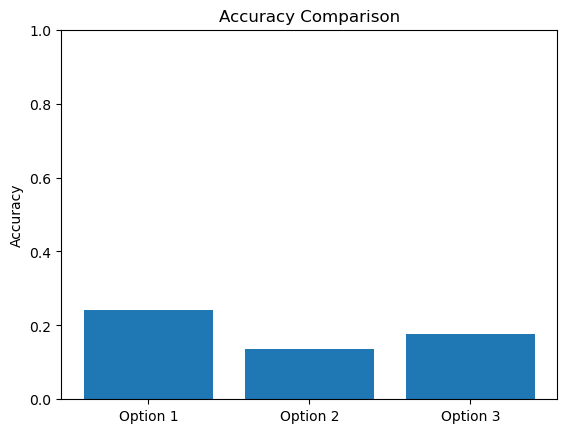

In [30]:
#Visualisierung der Ergebnisse
import matplotlib.pyplot as plt

# Accuracy values for the three options
accuracies = [accuracy_option1, accuracy_option2, accuracy_option3]

# Labels for the x-axis
options = ['Option 1', 'Option 2', 'Option 3']

# Plotting the bar graph
plt.bar(options, accuracies)
#plt.xlabel('Options')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim([0, 1])  # Set the y-axis limits between 0 and 1
plt.show()

## *6. Weitere Beispielvorführung*

In [31]:
skills_example = ['cad', 'maschinenbau', 'kostruktion', 'fräsen', 'drehen', 'montieren']

# Option 1: Doc2Vec
infer_vector_option1 = model_option1.infer_vector(skills_example)
similar_jobs_option1 = model_option1.dv.most_similar([infer_vector_option1], topn=3)
predicted_jobs_option1 = [job for job, similarity in similar_jobs_option1]
print("Option 1 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", predicted_jobs_option1)
print("")

# Option 2: Word2Vec
avg_option2 = averageOfSkills(model_option2, skills_example)
distVec_option2 = cdist([avg_option2], values_option2)
topJobs_option2 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option2.transpose(), keys_option2))]
print("Option 2 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", topJobs_option2)
print("")

# Option 3: Doc2Vec Embedding
avg_option3 = averageOfSkills(model_option3, skills_example)
distVec_option3 = cdist([avg_option3], values_option3)
topJobs_option3 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option3.transpose(), keys_option3))]
print("Option 3 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", topJobs_option3)
print("")

Option 1 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [5, 1, 25]

Option 2 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [7, 10, 11]

Option 3 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [10, 7, 11]

